In [1]:
import sys
sys.path.insert(0, "/users/jwindmil/2019_WMI/util")

# Initial imports
import Landau_Potential_Diffusion as Landau
import curvature as curve

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
import random
import pandas as pd
import dask.array as da
import matplotlib as mpl

import pickle

In [2]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [3]:
def cm_to_inch(m_cm):
    return m_cm/2.54

Plot settings

In [81]:
fz = 8
lw = 1
siz = 3

col_A = ['C0', 'C1', 'C2']

## Bimodality of CWV

i) ERA5 Data

ii) RCE simulation 

In [48]:
nbins = 30
xbins = np.linspace(10, 70, 31)

Use either kernel density estimate or PDF

In [10]:
switch_kde = False
method = 'KDE' if switch_kde else 'PDF'

### ERA5

In [26]:
per_thresh_era5 = 83

In [11]:
path_ERA = '/project/s916/ERA5_Tom/'

Restrict our analysis to a band of the tropical Atlantic

In [12]:
latmin = -23
latmax = 23
lonmin = 360-34
lonmax = 360-18

Select period (exclude 2018 as it is only partly available)

In [13]:
date1, date2 = np.datetime64('2000-01-01T00:00'), np.datetime64('2017-12-31T23:00')
dt = 3600

In [14]:
PW = xr.open_mfdataset(path_ERA+'????/??PW.nc',combine='by_coords', chunks={'time':100})

In [15]:
PWAtl = PW['tcwv'].sel({'time':slice(date1, date2), 'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})
lonAtl = PW.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = PW.latitude.sel({'latitude':slice(latmax,latmin)})

In [16]:
time_A = PWAtl.time.values

#### Temporal mean distribution

In [59]:
# chunk_sz = 1000
# ind_chunks = list(range(0, np.shape(PWAtl)[0], chunk_sz))+[np.shape(PWAtl)[0]]
# nbins = 30
# bin_edges = xbins #np.linspace(0, 80, nbins + 1)
# total = np.zeros(nbins, np.uint)

# for i in range(len(ind_chunks)-1):
#     print('i=',i, end='\r')
#     ind_start, ind_end = ind_chunks[i], ind_chunks[i+1]
#     data_chunk = np.ndarray.flatten(PWAtl[ind_start:ind_end,:,:].values)
#     subtotal, e = np.histogram(data_chunk, bin_edges)
#     total+= subtotal.astype(np.uint)
#     del data_chunk, subtotal, e

# hist_total = np.copy(total)
# np.savez('./PKL_DATA/CWV_hist_%i_%i_%i_%i_%i.npz'%(nbins, latmin, latmax, lonmin, lonmax), hist_total = hist_total, bin_edges = bin_edges)

dic_hist = np.load('./PKL_DATA/CWV_hist_%i_%i_%i_%i_%i.npz'%(nbins, latmin, latmax, lonmin, lonmax))

hist_total = dic_hist['hist_total']
bin_edges = dic_hist['bin_edges']

In [60]:
hist_cum = np.cumsum(hist_total)/np.sum(hist_total)

In [61]:
hist_total = hist_total/np.sum(hist_total)/(bin_edges[1]-bin_edges[0])

Load times of case

In [17]:
with open('./PKL_DATA/pik_times.dat', 'rb') as f:
    times_A = pickle.load(f)
times_A

[numpy.datetime64('2005-11-23T14:00:00.000000000'),
 numpy.datetime64('2005-12-04T14:00:00.000000000'),
 numpy.datetime64('2005-12-07T14:00:00.000000000')]

In [42]:
np.linspace(10, 70, 31)

array([10., 12., 14., 16., 18., 20., 22., 24., 26., 28., 30., 32., 34.,
       36., 38., 40., 42., 44., 46., 48., 50., 52., 54., 56., 58., 60.,
       62., 64., 66., 68., 70.])

2005-11-23T14:00:00.000000000 51.01881408691406
1.0000000000000002
2005-12-04T14:00:00.000000000 50.59869644165037
0.9999999999999999
2005-12-07T14:00:00.000000000 43.8817024230957
0.9999999999999999


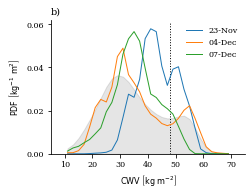

In [87]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
mpl.rcParams['lines.markersize'] = siz
plt.close('all')

fig,ax = plt.subplots(figsize=(cm_to_inch(9), cm_to_inch(7)))

x = np.linspace(10,75,161)



for i, time in enumerate(times_A):

    tmp = np.squeeze(PWAtl.sel({'time':slice(time-np.timedelta64(12,'h'), time+np.timedelta64(12,'h'))}).values) #np.squeeze(PWAtl.sel({'time':time}).values) #
    #tmp = np.squeeze(PWAtl.sel({'time':time}).values) 
    
    print(time, np.percentile(tmp, per_thresh_era5))
    
    if switch_kde:
        density = stats.gaussian_kde(np.ndarray.flatten(tmp))
        plt.plot(x, density(x), label = pd.to_datetime(time).strftime("%d-%b"), color = col_A[i])
    else:
        hist, edges = np.histogram(np.ndarray.flatten(tmp), density = True, bins = xbins)
        plt.plot(edgTObin(edges), hist, label = pd.to_datetime(time).strftime("%d-%b"), color = col_A[i])
        print(np.sum(hist*(edges[1:]-edges[:-1])))
    
    plt.legend(frameon=False)
    #plt.vlines([np.percentile(tmp, per_thresh_era5)], 0.0, ymax, linestyle=':', color = 'C%i'%i)
    
#plt.plot(bin_centers, hist_total, 'k')
plt.fill_between(bin_centers,hist_total, color = 'k',label='85d-100d', alpha = 0.1)
    
ymin, ymax = plt.ylim()
plt.vlines([48], 0.0, ymax, linestyle=':')
plt.ylim(0.0, 0.062)
plt.yticks([0.0, 0.02, 0.04, 0.06])
plt.xlim(xbins[0]-5, xbins[-1]+5)

ax.set_xlabel(r'$\mathrm{CWV}$ $\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{%s\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$'%method)


ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_title('b)', loc = 'left')
    
plt.tight_layout()

plt.savefig('./Figures/Fig1b.pdf', bbox_inches = "tight")

### RCE

Using the 506x506 simulation for consistency with Dave's work

In [7]:
path_RCE = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/output/'

In [8]:
RCE300 = xr.open_mfdataset(path_RCE+'lfff????????.nc', chunks={'time':100})

/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/jwindmil/venv-3.6/lib/python3.6/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [20]:
SPINstart = 0 #days
COALstart = 11 #days
COARstart = 25 #days
ENDstart = 85 # days

In [21]:
if switch_kde:
    density_SPIN = stats.gaussian_kde(np.ndarray.flatten(RCE300.TQV[:(24*COALstart),:,:].values))
    density_COAL = stats.gaussian_kde(np.ndarray.flatten(RCE300.TQV[(24*COALstart):(24*COARstart),:,:].values))
    density_COAR = stats.gaussian_kde(np.ndarray.flatten(RCE300.TQV[(24*ENDstart):,:,:].values))   
else:
    CWV_PDF_SPIN,SPINedges = np.histogram(RCE300.TQV[:(24*COALstart),:,:],bins=nbins,density=True)
    CWV_PDF_COAL,COALedges = np.histogram(RCE300.TQV[(24*COALstart):(24*COARstart),:,:],bins=nbins,density=True)
    CWV_PDF_COAR,COARedges = np.histogram(RCE300.TQV[(24*ENDstart):,:,:],bins=nbins,density=True)

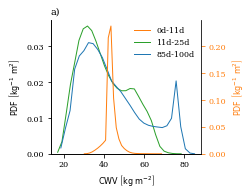

In [89]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
mpl.rcParams['lines.markersize'] = siz
plt.close('all')

fig,ax = plt.subplots(figsize=(cm_to_inch(9), cm_to_inch(7)))
ax2 = ax.twinx()

x = np.linspace(10,75,161)

if switch_kde:

    SPINline = ax2.plot(x, density_SPIN(x),color=col1,label='0d-11d')
    COALline = ax.plot(x, density_COAL(x),color=col2,label='11d-25d')
    COARline = ax.plot(x, density_COAR(x),color=col3,label='85d-100d')

else:
    SPINline = ax2.plot(edgTObin(SPINedges),CWV_PDF_SPIN,color=col1,label='0d-11d')
    COALline = ax.plot(edgTObin(COALedges),CWV_PDF_COAL,color=col2,label='11d-25d')
    COARline = ax.plot(edgTObin(COARedges),CWV_PDF_COAR,color=col3,label='85d-100d')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax2.spines['top'].set_visible(False)

ax2.tick_params(axis='y', labelcolor=col1)
ax2.set_ylabel(r'$\mathrm{%s\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$'%method, color = col1)
# ax2.spines['right'].set_color(col1)
ax2.tick_params(axis='y', colors=col1)

ax.set_ylim(ymin = 0.0)
ax2.set_ylim(ymin = 0.0)
ax.set_yticks([0.0,0.01,0.02,0.03])

# add legend for these three lines
lns = SPINline+COALline+COARline
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0, frameon=False)

ax.set_xlabel(r'$\mathrm{CWV}$ $\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{%s\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$'%method)

ax.set_title('a)', loc = 'left')

plt.tight_layout()
plt.savefig('./Figures/Fig1a.pdf', bbox_inches = "tight")